## Interaction network template
Produces an interaction edgelist from a ```.mymridon``` experiment file and saves it as a csv, which can be further analyzed in the optional part or exported into other software such as RStudio.  
This notebook is a walk trough a sample usage of the following:
* the py-myrmidon library ([Documentation](https://formicidae-tracker.github.io/myrmidon/latest/))
* the facetnet library ([Documentation](https://c4science.ch/source/facet_unil/))


In [1]:
import py_fort_myrmidon as fm
import numpy as np  # Fundamental math library in python. Here used only for convience: to save the csv.
from datetime import datetime, timedelta  # For convenient handling of time and date
import networkx as nx  # Optional: for general graph analysis and plotting
import facetnet  # Optional: for community analysis
import matplotlib.pyplot as plt  # Optional: for plotting
import pandas as pd
# Optional: makes plots interactive:
#%matplotlib widget

In [2]:
#f_myrmidon = "/home/user/Documents/experiment_folder/exp.myrmidon"
# f_myrmidon = "/media/egeorge/Elements/Woundcare Experiment3/woundcare_cfell54_T3.myrmidon"
f_myrmidon = "/media/egeorge/Ebi-4/InfectionExp_Cfel13/InfectionExp_Cfel13.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
t_start = datetime(2023, 4, 19, 0, 0).astimezone(tz=None)  # <year, month, day, hour, minute>
t_end = datetime(2023, 4, 23, 23, 59).astimezone(tz=None)

The following is an iterator for fort mymrmidon time over days in a period. See Ant metadata template for explanation.

In [3]:
def fm_time_range(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield fm.Time(start_datetime + timedelta(n))

### Create and output edgelists

A matcher is used to filter interactions of a certain type ("body part 1 with body part 1") that were recorded during a user define period from ```t_start``` to ```t_end```. The ```for``` loop takes the ```ant_id``` of both individuals invovled in the interaction and updates the egde weight in the count graph, as well as in the interaction duration graph. The two edge lists are then saved to csv with name that consists of the experiment name and the dates. This is to avoid confusion, any string can serve as a file name.

In [4]:
m = fm.Matcher.InteractionType(1, 1)

G_counts = nx.Graph()
G_counts.add_nodes_from(exp.Ants.keys())
G_seconds = nx.Graph()
G_seconds.add_nodes_from(exp.Ants.keys())

for t_begin in fm_time_range(t_start, t_end):
    interactions = fm.Query.ComputeAntInteractions(exp,
                                                   start=t_begin,
                                                   end=t_begin.Add(fm.Duration.Parse('24h')),
                                                   matcher=m)
    for ia in interactions[1]:
        if G_counts.has_edge(ia.IDs[0], ia.IDs[1]):
            G_counts[ia.IDs[0]][ia.IDs[1]]['weight'] += 1
        else:
            G_counts.add_edge(ia.IDs[0], ia.IDs[1], weight=1)
            
        if G_seconds.has_edge(ia.IDs[0], ia.IDs[1]):
            G_seconds[ia.IDs[0]][ia.IDs[1]]['weight'] += (ia.End - ia.Start).Seconds()
        else:
            G_seconds.add_edge(ia.IDs[0], ia.IDs[1], weight=(ia.End - ia.Start).Seconds())

#f_edgelist_ct = "edgelist_interaction_counts_{}_{}_{}.csv".format(exp.Name, t_start, t_end)
#f_edgelist_sec = "edgelist_interaction_seconds_{}_{}_{}.csv".format(exp.Name, t_start, t_end)

# Alternate filenames to work with windows and for edgelists within a 24 hour period
day_exp = t_start.strftime('%Y%m%d')
hr_strt = t_start.strftime('%H%M')
hr_end = t_end.strftime('%H%M')

f_edgelist_ct = "edgelist_interaction_counts_{}_{}_{}-{}.csv".format(exp.Name, day_exp, hr_strt, hr_end)
f_edgelist_sec = "edgelist_interaction_seconds_{}_{}_{}-{}.csv".format(exp.Name, day_exp, hr_strt, hr_end)

nx.write_edgelist(G_counts, f_edgelist_ct)
nx.write_edgelist(G_seconds, f_edgelist_sec)

Computing ant interactions:   0%|             | 0/1440 [00:49<?, ?tracked min/s]


#### Remove outliers/misidentified ants

Often there may be outliers which are due to some tags being misidentified in fort-studio. We can use the degree to determine these ant IDs and remove them from the edgelist. In this case the threshold we use to detrmine if an ant is misidentified depends on the time duration of the experiment or the time range over which we are extracting the edgelists and needs to be changed accordingly

In [ ]:
# Code for removing outliers - ant tags that were misidentified and hence have very low collisions/interactions
# Get sorted list of degree per node to identify outliers to remove
degree_dict = {node:val for (node, val) in G_counts.degree()}
degree_dict_sort = {k: v for k, v in sorted(degree_dict.items(), key=lambda item: item[1])}
remove = [node for node,degree in dict(G_counts.degree()).items() if degree < 50]
G_counts.remove_nodes_from(remove)
f_edgelist_ct = "edgelist_counts_removed_{}_{}_{}.csv".format(exp.Name, t_start, t_end)

nx.write_edgelist(G_counts, f_edgelist_ct)

#### Combining edgelists when data is corrputed

This works by first outputting multiple edgelists which don't overlap with the range of time when the data corruption happened. After this we read in the edgelists and combine them.
We can also skip the step of outputting multiple edgelists by not writing them to a CSV if needed. In this case we directly create multiple graphs from the experiemntal data, combine them as below and output one edgelist CSV

In [5]:
# Code to combine edgelists. Only useful when there is data corruption leading to 2 or 3 edgelists that need to be extracted leaving out the corrupted data
import pandas as pd
import networkx as nx
G1_c = nx.read_edgelist("edgelist_interaction_counts_Woundcare_cfell1_T2_2022-05-31 00:01:00+02:00_2022-06-02 23:59:00+02:00.csv", nodetype=int)
G2_c = nx.read_edgelist("edgelist_interaction_counts_Woundcare_cfell1_T2_2022-06-04 06:01:00+02:00_2022-06-04 23:59:00+02:00.csv", nodetype=int)
G1_s = nx.read_edgelist("edgelist_interaction_seconds_Woundcare_cfell1_T2_2022-05-31 00:01:00+02:00_2022-06-02 23:59:00+02:00.csv", nodetype=int)
G2_s = nx.read_edgelist("edgelist_interaction_seconds_Woundcare_cfell1_T2_2022-06-04 06:01:00+02:00_2022-06-04 23:59:00+02:00.csv", nodetype=int)
n_G1 = list(G1_c)
n_G2 = list(G2_c)
missing_G1 = [item for item in n_G2 if item not in n_G1] # AntID 57 present in G2 and has only interacted with 26 twice and with no other ant
# Convert to pandas dataframes, and combine dataframes with summation of weights
pG1_c = nx.to_pandas_edgelist(G1_c)
pG2_c = nx.to_pandas_edgelist(G2_c)
pG_c = pd.concat([pG1_c, pG2_c]).groupby(['source', 'target']).sum().reset_index()
# Convert back to networkx graph
G_counts = nx.from_pandas_edgelist(pG_c, edge_attr=True)
# Removing antID 57 from the Graph as it is wrongly tagged in all likelihood
G_counts.remove_node(57)
# Convert to pandas dataframes, and combine dataframes with summation of weights
pG1_s = nx.to_pandas_edgelist(G1_s)
pG2_s = nx.to_pandas_edgelist(G2_s)
pG_s = pd.concat([pG1_s, pG2_s]).groupby(['source', 'target']).sum().reset_index()
# Convert back to networkx graph
G_seconds = nx.from_pandas_edgelist(pG_s, edge_attr=True)
# Removing antID 57 from the Graph as it is wrongly tagged in all likelihood
G_seconds.remove_node(57)
f_edgelist_ct = "edgelist_interaction_counts_{}_{}_{}.csv".format(exp.Name, t_start, t_end)
f_edgelist_sec = "edgelist_interaction_seconds_{}_{}_{}.csv".format(exp.Name, t_start, t_end)

nx.write_edgelist(G_counts, f_edgelist_ct, data=True)
nx.write_edgelist(G_seconds, f_edgelist_sec, data=True)

### Optional part 1: graph visualization using networkx library
For convenience, the facetnet library is used and the previously written csv is parsed again. There are other, more elegant ways to do this. The grap is plotted using the spring model, a common way to visualize graphs.

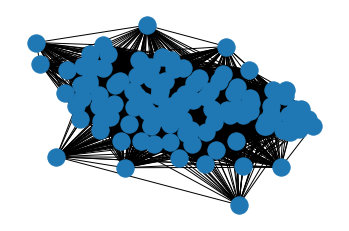

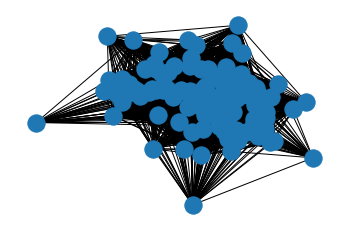

In [6]:
G_counts.remove_nodes_from(list(nx.isolates(G_counts)))  # Nodes without any interactions are removed
G_seconds.remove_nodes_from(list(nx.isolates(G_seconds)))
fig,ax=plt.subplots()
nx.draw_spring(G_counts)
fig,ax=plt.subplots()
nx.draw_spring(G_seconds)

### Optional part 2: community detection using facetnet
A fixed number of community is assumed. Facetnet returns a resulting soft modularity score of the community detection, as well as the soft community membership for each individual and each community, which can be understood as membership "percentage". The graph is then plotted again with a node color representing community membership. Facetnet can also be used as a command line tool to process the saved csv directly.

soft modularity score: -26294211049.284878


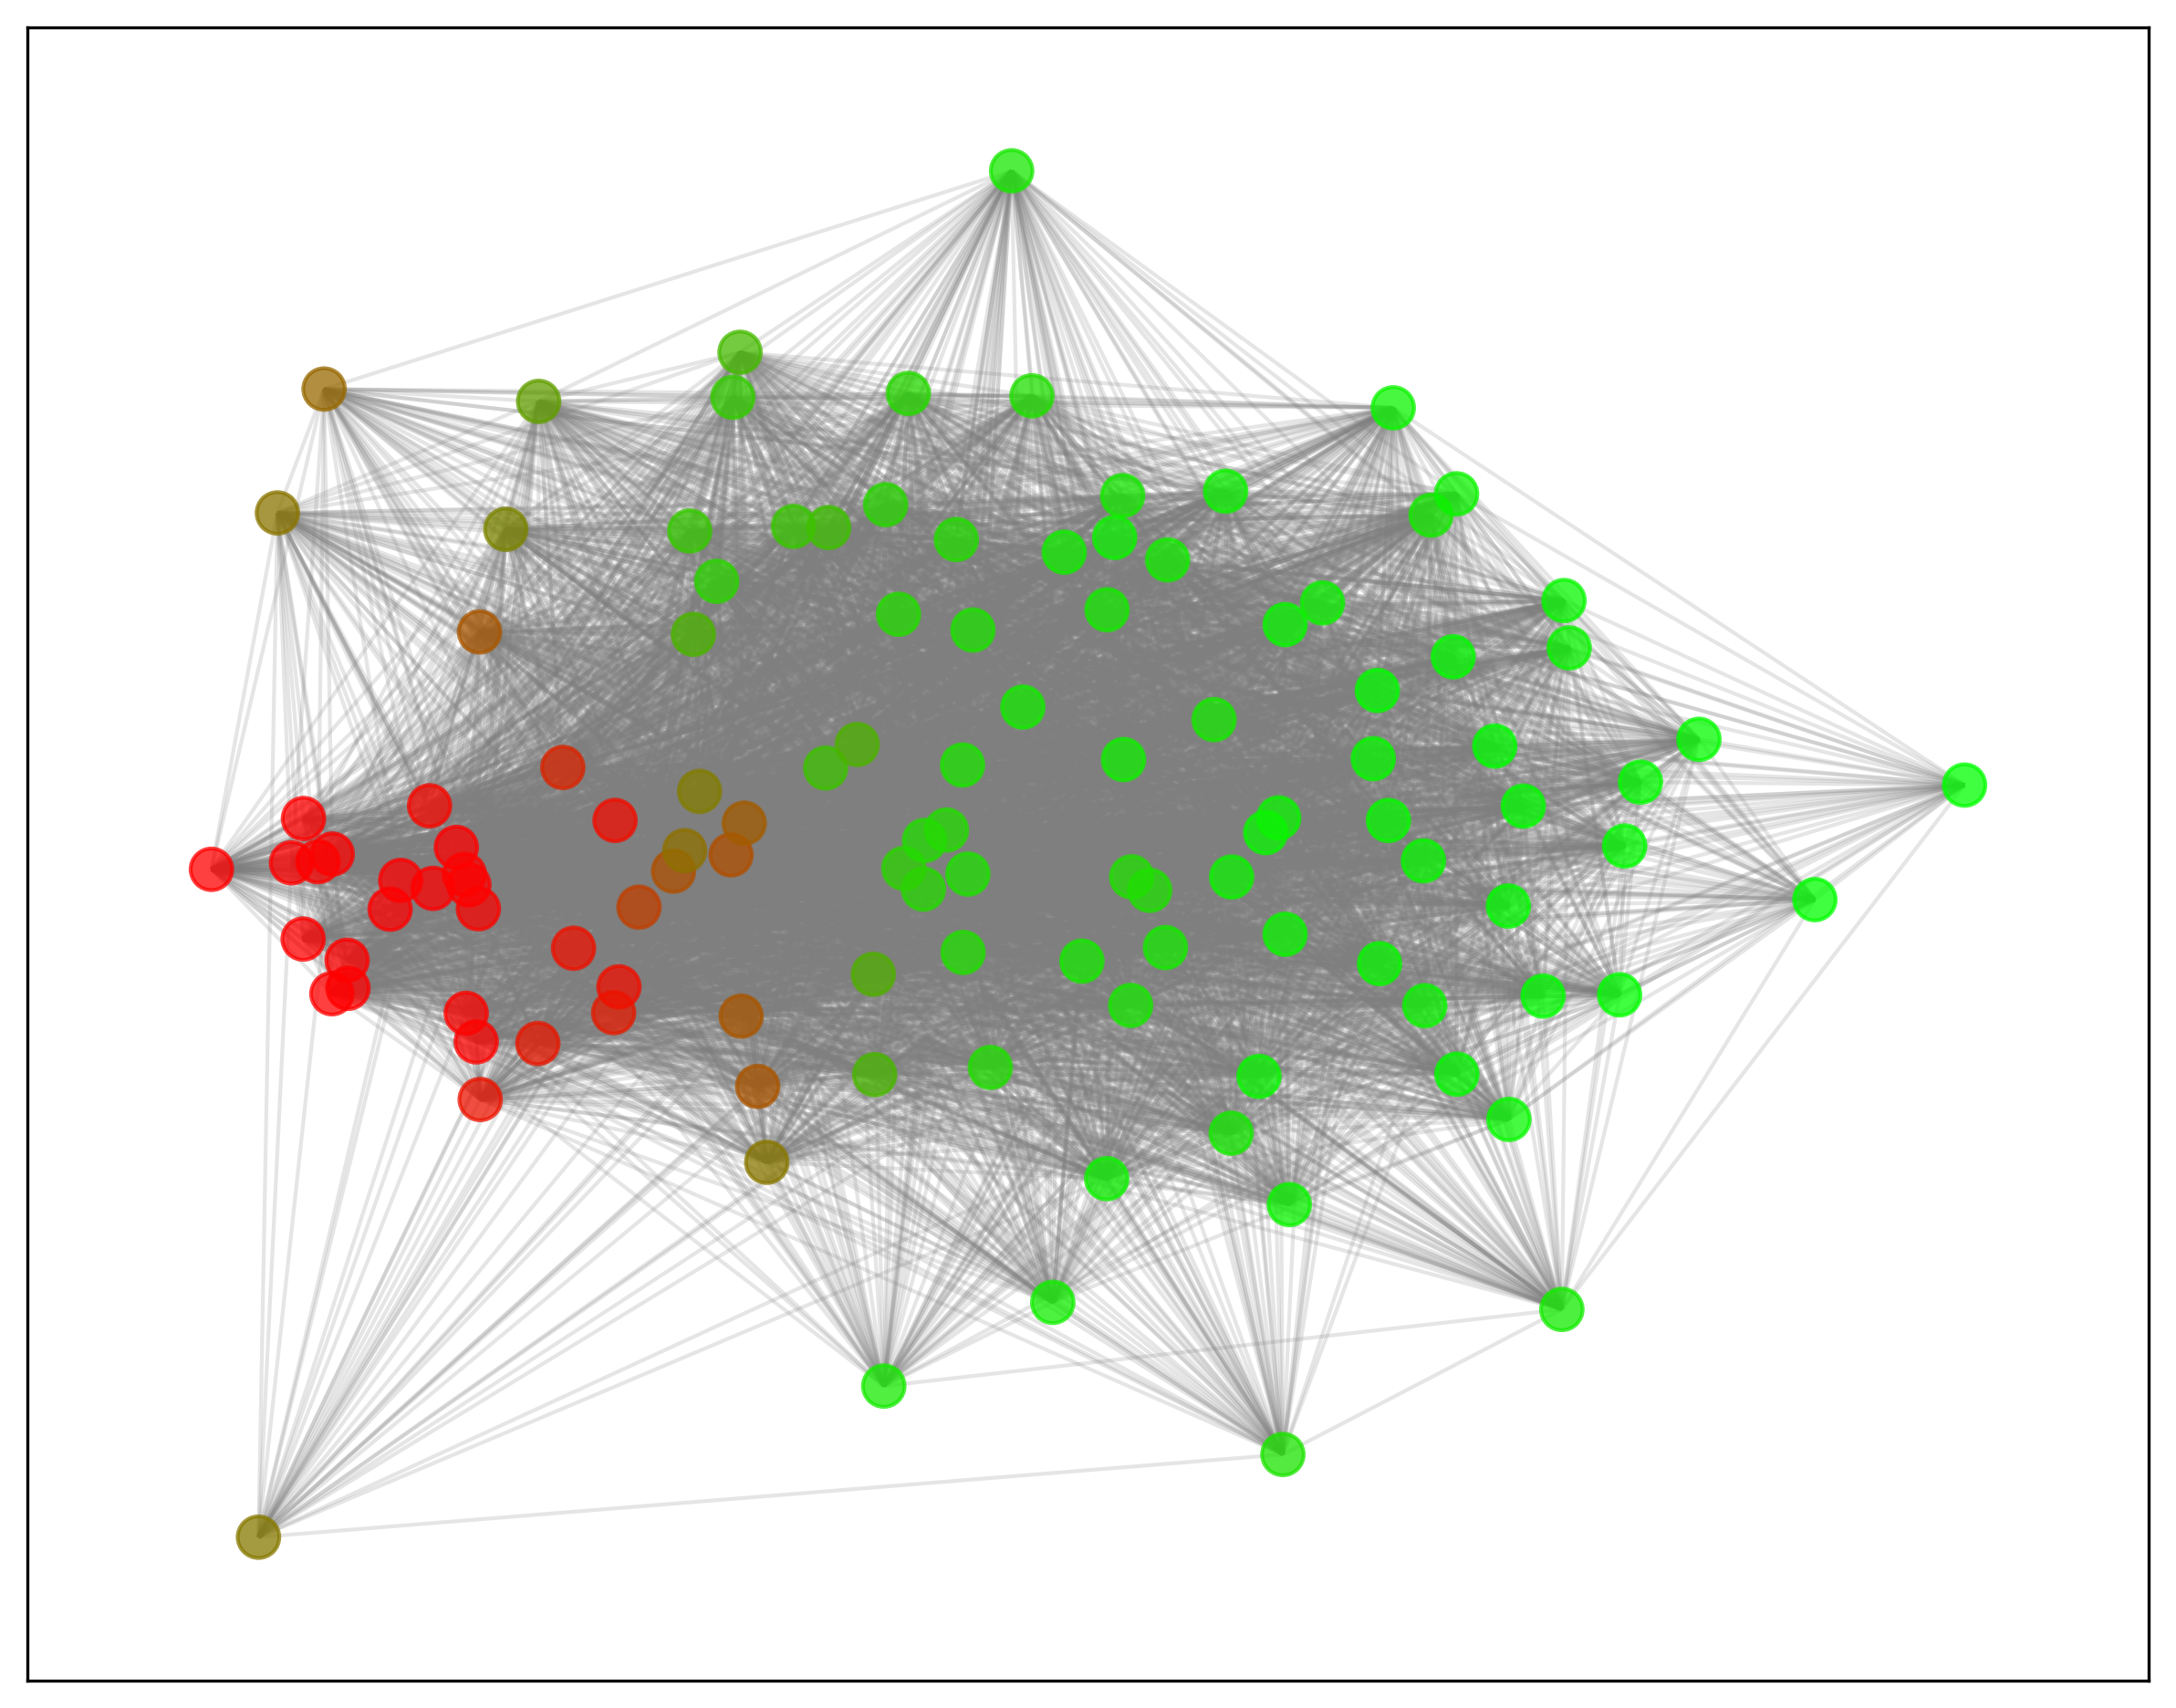

In [16]:
np.random.seed(12345678) # set seed for reproducibility
nb_communities = 2
wc = nx.to_numpy_matrix(G_counts)
idmap = G_counts.nodes
idmap_inv = {nid: i for i, nid in enumerate(idmap)}
dat_fn = facetnet.step(idmap,
                       idmap_inv,
                       wc,
                       0.7,
                       nb_communities,
                       show_plot=False)

# Plot resulting communities as colored node. Remove zero count individuals.
soft_comm = dat_fn[5]
# fig, ax = plt.subplots()
color_nodes = []
for i in range(len(soft_comm)):
    # red, green, blue value. Red means community 0, green means community 1
    color_nodes.append((soft_comm[i, 0], soft_comm[i, 1], 0))
# options = {"edgecolors": "tab:gray", "node_size": 120, "alpha": 0.25}
# options = {"edge_color": "gray", "node_size": 120, "alpha": 0.5}
# nx.draw_spring(G_counts, node_color=np.asarray(color_nodes), **options)
fig=plt.figure(figsize=(10,8), dpi=300)
pos=nx.spring_layout(G_counts, seed=1234567)
nx.draw_networkx_nodes(G_counts, pos, node_color=np.asarray(color_nodes), alpha=0.75, node_size=120)
nx.draw_networkx_edges(G_counts, pos, edge_color="tab:gray", alpha=0.2)
fig.savefig("Woundcare_Inf_Cfel13_baseline_SM.png")
print("soft modularity score: {}".format(dat_fn[4]))

#### Output Social Maturity CSV with known queen ID

Once the queen ID is known we can determine which of the communities has the highest membership score for the queen. The social maturity is the membership values of the other community(s). We then output this as a CSV with a few extra columns

In [28]:
# Output social maturity scores based on known queen ID
import pandas as pd
queen_id = 33
i_q = list(idmap).index(queen_id) # Extract index of queen from idmap, first element output by facetnet
queen_comm = np.argmax(dat_fn[5][i_q]) # Identify which of the communities has the highest value for the Queen. This is the queen community, and hence (1-social maturity values)
soc_mat = pd.DataFrame(dat_fn[5][:, queen_comm], columns=["soc_mat"])
soc_mat['soc_mat'] = 1 - soc_mat['soc_mat'] # Subtracting 1 from Queen community value to get the forager community value/social maturity value. In case there are more than 2 communities, the social maturity value is the summation of all the non-queen community values
soc_mat['antID'] = dat_fn[0] # Add the antIDs to the community membership values
soc_mat['queen'] = np.where(soc_mat['antID'] == queen_id, 1, 0)
soc_mat.to_csv("social_maturity_scores_{}_{}_{}.csv".format(exp.Name, t_start, t_end),index=False)

### Additional code for removal experiments

For the removal experiments in which ants are removed from the colony based on their social maturity values, some aditional code is required.
We first get a list of ants with social maturity values below a threshold.
We can then obtain the list of nodes (antIDs) that were removed and recreate the pre-removal network with these individuals removed. This can then be used to obtain the social maturity of the remaining individuals giving us social maturity values with and without the removed individuals in the pre-removal phase


In [ ]:
# Code to obtain list of antIDs below/above a certain social maturity value
sm1 = soc_mat.sort_values(by=["soc_mat"])[soc_mat["soc_mat"] < 0.5]
sm1.to_csv("social_maturity_RemovalTest2_AntstoRemove.csv",index=False)

In [25]:
# Code to obtain social maturity distribution of pre-removal networks without the ants which are removed during the experiment
# Load social maturity datasets
sm_pre = pd.read_csv("social_maturity_scores_RemovalTest2_Pre_20220727-20220731.csv")
sm_post = pd.read_csv("social_maturity_scores_RemovalTest2_Post_20220803-20220807.csv")
# Obtain list of nodes that were removed
removed = list(set(sm_pre["antID"].tolist()).difference(sm_post["antID"].tolist()))
# Load pre removal edgelist of interaction counts
G_counts_pre = nx.read_edgelist("edgelist_interaction_counts_RemovalTest2_Pre_20220727-20220731.csv", nodetype=int)
# Remove nodes from the graph that correspond to removed ants
G_counts_pre.remove_nodes_from(removed)
nx.write_edgelist(G_counts_pre, "edgelist_interaction_counts_RemovalTest2_PreModified_20220727-20220731.csv")

In [26]:
# Load pre removal edgelist of interaction seconds
G_seconds_pre = nx.read_edgelist("edgelist_interaction_seconds_RemovalTest2_Pre_20220727-20220731.csv", nodetype=int)
# Remove nodes from the graph that correspond to removed ants
G_seconds_pre.remove_nodes_from(removed)
nx.write_edgelist(G_seconds_pre, "edgelist_interaction_seconds_RemovalTest2_PreModified_20220727-20220731.csv")

In [16]:
# Plot modified pre-removal interaction graph
fig,ax=plt.subplots()
nx.draw_spring(G_counts_pre)

soft modularity score: -14194191249.108082


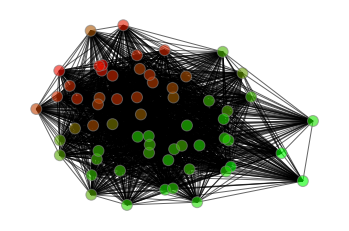

In [22]:
# Run facetnet algorithm over modified graph
np.random.seed(12345678) # set seed for reproducibility
nb_communities = 2
wc = nx.to_numpy_matrix(G_counts_pre)
idmap = G_counts.nodes
idmap_inv = {nid: i for i, nid in enumerate(idmap)}
dat_fn = facetnet.step(idmap,
                       idmap_inv,
                       wc,
                       0.7,
                       nb_communities,
                       show_plot=False)

# Plot resulting communities as colored node. Remove zero count individuals.
soft_comm = dat_fn[5]
fig, ax = plt.subplots()
color_nodes = []
for i in range(len(soft_comm)):
    # red, green, blue value. Red means community 0, green means community 1
    color_nodes.append((soft_comm[i, 0], soft_comm[i, 1], 0))
options = {"edgecolors": "tab:gray", "node_size": 120, "alpha": 0.6}
nx.draw_spring(G_counts_pre, node_color=np.asarray(color_nodes), **options)
print("soft modularity score: {}".format(dat_fn[4]))

In [23]:
# Output social maturity scores based on known queen ID
import pandas as pd
queen_id = 1
i_q = list(idmap).index(queen_id) # Extract index of queen from idmap, first element output by facetnet
queen_comm = np.argmax(dat_fn[5][i_q]) # Identify which of the communities has the highest value for the Queen. This is the queen community, and hence (1-social maturity values)
soc_mat = pd.DataFrame(dat_fn[5][:, queen_comm], columns=["soc_mat"])
soc_mat['soc_mat'] = 1 - soc_mat['soc_mat'] # Subtracting 1 from Queen community value to get the forager community value/social maturity value. In case there are more than 2 communities, the social maturity value is the summation of all the non-queen community values
soc_mat['antID'] = dat_fn[0] # Add the antIDs to the community membership values
soc_mat['queen'] = np.where(soc_mat['antID'] == queen_id, 1, 0)
soc_mat.to_csv("social_maturity_scores_{}_PreModified_20220727-20220731.csv".format(exp.Name),index=False)